In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# Author: SunilKumarJB@ sramv@

# Getting Started with NLP2SQL using dynamic RAG using

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/NLP2SQL_using_dynamic_RAG.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Fretrieval-augmented-generation%2F%2FNLP2SQL_using_dynamic_RAG.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/NLP2SQL_using_dynamic_RAG.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/NLP2SQL_using_dynamic_RAG.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Sunil Kumar Jang Bahadur](https://www.linkedin.com/in/sunilkumar88/),  [Vijay Surampudi](https://www.linkedin.com/in/vijaysurampudi)|

## Overview

This notebook showcases how to utilize the "Dynamic RAG based few shot examples" approach to generate NLP2SQL outputs more reliably and accurately using the Vertex AI SDK for Python via the Gemini 1.0 Pro model (`gemini-1.0-pro`).

Gemini 1.0 Pro model (`gemini-1.0-pro`) supports prompts with text-only input, including natural language tasks, multi-turn text and code chat, and code generation. It can output text and code.

### Objectives

This tutorial will guide you through the process of using “Dynamic RAG based Few shot examples to modify a prompt's few shot examples based on a provided input query. By utilizing the Gemini 1.0 Pro model (`gemini-1.0-pro`) in conjunction with the Vertex AI SDK for Python, you will be able to generate SQL code or any other type of code with higher accuracy.

You will complete the following tasks:

- Explore the Dynamic RAG-Based Few-Shot Examples Workflow Element by Element

  Understand how each element of the Dynamic RAG-based few-shot examples workflow contributes to the overall process.

- The Role of Multilingual Embeddings in Knowledge Transfer

  Delve into how multilingual embeddings facilitate the use of a knowledge base created in any supported language without the need for translation.



### Reference architecture of Dynamic RAG based few shot examples

### Costs
This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

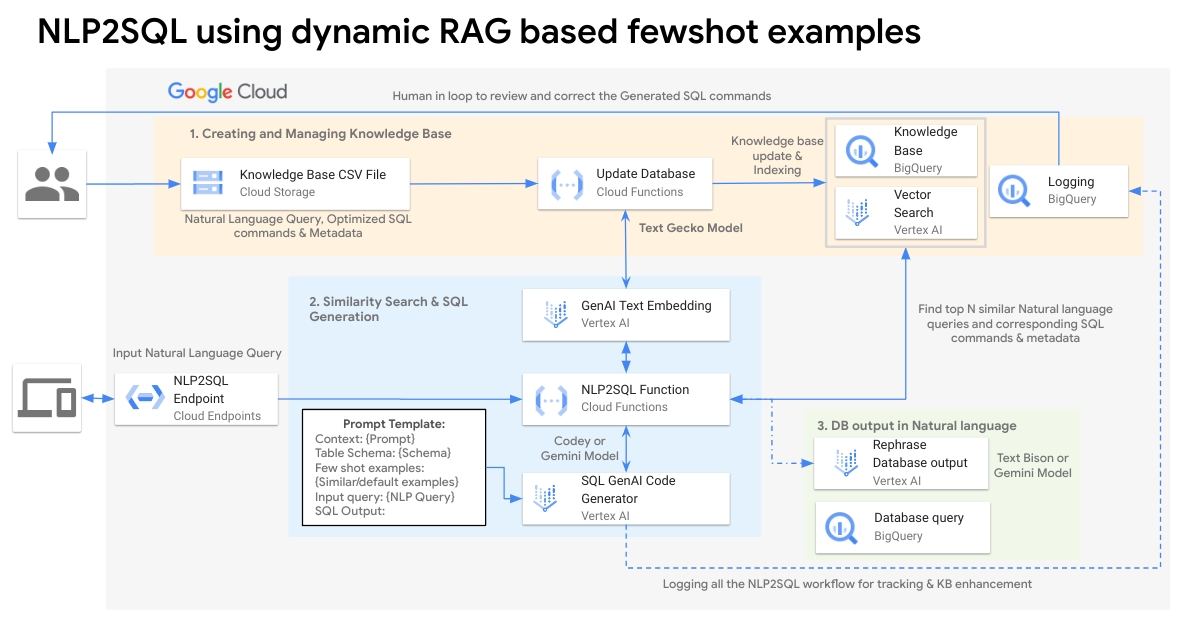

## Step 1: Installing the Dependencies required

### Step 1.1: Install libraries


In [ ]:
# Installing dependencies

!pip install --upgrade google-cloud-aiplatform google-cloud-storage
!pip install "bigframes<1.0.0"

### Step 1.2 Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After its restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ Wait for the kernel to finish restarting before you continue. ⚠️</b>
</div>

### Step 1.3 Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the cell below to authenticate your environment.

This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Step 1.4 Define Google Cloud project information and initialize Vertex AI

Initialize the Vertex AI SDK for Python for your project:

In [ ]:
# Define project information
PROJECT_ID = "PROJECT_ID"  # @param {type:"string"}
LOCATION = "LOCATION"  # @param {type:"string"}
BATCH_SIZE = 5

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Step 1.5 Import libraries

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import time
import tqdm  # to show a progress bar

from vertexai.language_models import TextEmbeddingModel, CodeGenerationModel
from vertexai.generative_models import Content, GenerativeModel, Part

### Step 2: Indexing the Knowledge Base

### Step 2.1 Load the gemini, codey & text embedding model
[List of languages supported in Multilingual embedding model](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings#language_coverage_for_textembedding-gecko-multilingual_models)



In [ ]:
# Load the code & text embeddings model
embedd_model = TextEmbeddingModel.from_pretrained(
    "textembedding-gecko-multilingual@001"
)
gemini_model = GenerativeModel("gemini-1.0-pro")
code_model = CodeGenerationModel.from_pretrained("code-bison")

### Step 2.2 Knowledge base CSV to Dataframe. This could be a database as well, but lets consider CSV for now.
Upload the CSV file from the git hub to colab


In [ ]:
# Reading the CSV file containing Knowledge Base of sample queries
df = pd.read_csv("queries_sample_knowledge_base.csv")

print(df.to_string())

   id                                                                                   question                                                                                                                                                                                         query_1                                        query_1_explanation     Additional Metadata (If any)
0   1  How many points are accrued in the month of Oct 2023 for transactions on Online Shopping?                                        SELECT\n  *\nFROM\n  `demo_project.cc_demo_dataset.txn-detail-tab`\nWHERE\n  Online_transaction = TRUE\n  AND Date BETWEEN '2023-10-01' AND '2023-10-31'        Each row showing one transaction of online shopping          Any useful product link
1   2            Why are there some transactions in Oct 2023 for which I don't see award points?                                               SELECT\n  *\nFROM\n  `demo_project.cc_demo_dataset.txn-detail-tab`\nWHERE\n  Points_Accrued = 0

### Step 2.3 Retrieve Embeddings using APIs for given text

In [ ]:
def get_embeddings_wrapper(texts):
    """
    This function retrieves embeddings for a list of texts using the provided embedding model,
    handling batching and rate limiting to avoid exceeding API quotas.

    Args:
        texts (list): A list of text strings.

    Returns:
        list: A list of embedding vectors for each text in the input list.
    """

    embs = []
    for i in tqdm.tqdm(range(0, len(texts), BATCH_SIZE)):
        # Sleep for 1 second to avoid exceeding API quotas.
        time.sleep(1)

        # Get embeddings for the current batch of texts.
        result = embedd_model.get_embeddings(texts[i : i + BATCH_SIZE])

        # Extract and append the embedding vectors to the list.
        embs = embs + [e.values for e in result]

    return embs

### Step 2.4 Generate embedding of all the natural language queries

In [ ]:
# Get embeddings for the questions and assign them to a new column.
df = df.assign(embedding=get_embeddings_wrapper(list(df.question)))
df.head()

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


,id,question,query_1,query_1_explanation,Additional Metadata (If any),embedding
0,1,How many points are accrued in the month of Oc...,SELECT\n *\nFROM\n `demo_project.cc_demo_dat...,Each row showing one transaction of online sho...,Any useful product link,"[0.03033534437417984, -0.01754842698574066, 0...."
1,2,Why are there some transactions in Oct 2023 fo...,SELECT\n *\nFROM\n `demo_project.cc_demo_dat...,The list of transactions for which Award Point...,Any upsell or cross sell offers,"[0.02858484536409378, 0.0016411978285759687, 0..."
2,3,What are the FCY markup charges that I see on ...,SELECT\n*\nFROM\n `demo_project.cc_demo_datas...,FCY Markup Transaction and Charges,Any useful information links,"[0.01185921672731638, 0.0162956602871418, 0.02..."
3,4,Can I get details on the Foreign Currency Tran...,SELECT\n *\nFROM\n `demo_project.cc_demo_dat...,FCY Transactions and their markup charges,NaN,"[0.03950844332575798, -0.047629840672016144, 0..."
4,5,What are the negative transactions or Refunds ...,SELECT\n *\nFROM\n `demo_project.cc_demo_dat...,Negative Transactions or Refunds in the Month ...,NaN,"[0.01964464597404003, -0.01865999959409237, 0...."


### Step 2.5 Create JSON file to be used for Vector Store

In [ ]:
# save id and embedding as a json file
jsonl_string = df[["id", "embedding"]].to_json(orient="records", lines=True)
with open("questions.json", "w") as f:
    f.write(jsonl_string)

# show the first few lines of the json file
! head -n 3 questions.json

{"id":1,"embedding":[0.0303353444,-0.017548427,0.0471334234,0.0382850021,-0.0570741221,0.0002702833,-0.008171034,0.0035157243,0.0092458352,0.0367915519,0.0152511345,0.0086202072,0.0103061842,-0.078585051,0.0007488361,-0.0114573082,0.0252783895,-0.0644235313,-0.0662875548,0.0081980191,-0.0412773751,0.0412367173,-0.069454357,-0.0448970683,0.0018960165,-0.0188018903,0.0723277852,-0.0208567679,-0.0349735171,-0.0154310046,-0.1064747646,-0.0351373628,0.0458807424,0.0049169394,-0.0076076407,0.0209584367,0.0147078568,-0.0061008008,-0.0062737288,0.0272605456,0.0536958054,-0.0581914335,-0.093259424,0.0183988456,0.0111667886,-0.0144215161,-0.0105351098,0.0203574467,0.0506270528,0.006549397,0.0290367529,0.0081006894,0.0086603612,0.0158555247,-0.029483743,-0.0131679261,0.0263352226,-0.0147279091,-0.0566217676,0.0147200199,0.0427949578,0.0080850674,-0.0137850782,0.0595780052,-0.0233665798,0.0033843908,-0.039484486,0.0230140183,0.035362225,0.0053502042,0.0176799651,-0.0231888648,-0.0494541787,-0.0060

### Local Similarity Search Test Run using only Dataframe

In [ ]:
text_query = (
    "Can i get transaction details done in offshore currency"  # @param {type:"string"}
)
test_embeddings = get_embeddings_wrapper([text_query])
print(test_embeddings)

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

[[0.02670329622924328, -0.06561632454395294, 0.039728984236717224, 0.015330135822296143, -0.04961904510855675, -0.04559426009654999, 0.00017789840057957917, -0.0005180778098292649, -0.043920986354351044, 0.0034636303316801786, -0.004833780229091644, -0.053800735622644424, 0.030155859887599945, -0.01909491792321205, 0.049250055104494095, -0.012286501005291939, 0.05542847514152527, -0.04032176733016968, -0.1282789409160614, -0.011726150289177895, -0.01910519227385521, 0.015157917514443398, -0.022243639454245567, -0.01723719947040081, 0.013669786974787712, -0.003207692876458168, 0.003951258026063442, -0.01608867384493351, -0.053406454622745514, 0.03166099637746811, -0.055368974804878235, -0.024749701842665672, -0.006628101225942373, -0.013896701857447624, -0.02536821737885475, 0.03760921582579613, 0.012148112058639526, 0.02140650525689125, 0.02005300112068653, 0.054034046828746796, 0.04031268507242203, -0.04828718304634094, -0.09804730862379074, -0.0142063582316041, 0.019286509603261948, 

In [ ]:
# Convert the embeddings column of the DataFrame to a numpy array.
embs = np.array(df.embedding.to_list())

# Calculate the similarity scores between the text query and each question.
similarities = np.dot(test_embeddings[0], embs.T)

In [ ]:
print(similarities)

[0.64324102 0.68157103 0.64257608 0.80207978 0.6710179 ]


In [ ]:
# print the question
print(f"Key question: Can i get transaction details done in offshore currency")

# sort and print the questions by similarities
sorted_questions = sorted(
    zip(df.question, similarities, df.query_1), key=lambda x: x[1], reverse=True
)[:10]

for i, (question, similarity, query_1) in enumerate(sorted_questions):
    print(f"\n \n Similarity: {similarity}: {question}")
    print(f"SQL Query: {query_1}")

Key question: Can i get transaction details done in offshore currency

 
 Similarity: 0.802079777589348: Can I get details on the Foreign Currency Transactions through Oct 2023?
SQL Query: SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Foreign_Currency = TRUE
OR 
Transaction_Description LIKE 'FCY%'
AND Date BETWEEN '2023-10-01' AND '2023-10-31'

 
 Similarity: 0.6815710317649311: Why are there some transactions in Oct 2023 for which I don't see award points?
SQL Query: SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Points_Accrued = 0
  AND Date BETWEEN '2023-10-01' AND '2023-10-31'

 
 Similarity: 0.6710179049041647: What are the negative transactions or Refunds seen in the Month of Oct 2023
SQL Query: SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Value < 0
  AND Date BETWEEN '2023-10-01' AND '2023-10-31'

 
 Similarity: 0.6432410202104142: How many points are accrued in the month of Oct 2023 for transactions o

In [ ]:
def find_similar_questions(df, text_query):
    """
    This function finds the most similar questions to a given text query.

    Args:
        df (pd.DataFrame): A DataFrame containing question-answer pairs.
            The DataFrame should have the following columns:
            - question: The question text.
            - query_1: The query text.
            - embedding: The embedding vector of the question.
        text_query (str): The text query to compare against.

    Returns:
        list: A list of the 10 most similar questions and their similarity scores.
    """

    # Get the embedding vector of the text query.
    test_embeddings = get_embeddings_wrapper([text_query])

    # Convert the embeddings column of the DataFrame to a numpy array.
    embs = np.array(df.embedding.to_list())

    # Calculate the similarity scores between the text query and each question.
    similarities = np.dot(test_embeddings[0], embs.T)

    # Sort the questions by similarity score and return the top 10.
    sorted_questions = sorted(
        zip(df.question, similarities, df.query_1), key=lambda x: x[1], reverse=True
    )[:10]

    # Print the top 10 questions and their similarity scores.
    for i, (question, similarity, query_1) in enumerate(sorted_questions):
        print(f"\n \n Similarity: {similarity}: {question}")
        print(f"SQL Query: {query_1}")

In [ ]:
text_query = (
    "Can i get transaction details done in offshore currency"  # @param {type:"string"}
)
find_similar_questions(df, text_query)

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


 
 Similarity: 0.802079777589348: Can I get details on the Foreign Currency Transactions through Oct 2023?
SQL Query: SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Foreign_Currency = TRUE
OR 
Transaction_Description LIKE 'FCY%'
AND Date BETWEEN '2023-10-01' AND '2023-10-31'

 
 Similarity: 0.6815710317649311: Why are there some transactions in Oct 2023 for which I don't see award points?
SQL Query: SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Points_Accrued = 0
  AND Date BETWEEN '2023-10-01' AND '2023-10-31'

 
 Similarity: 0.6710179049041647: What are the negative transactions or Refunds seen in the Month of Oct 2023
SQL Query: SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Value < 0
  AND Date BETWEEN '2023-10-01' AND '2023-10-31'

 
 Similarity: 0.6432410202104142: How many points are accrued in the month of Oct 2023 for transactions on Online Shopping?
SQL Query: SELECT
  *
FROM
  `demo_project.cc_demo_

### Multi-lingual Test Run

In [ ]:
text_query = "展示Foreign Currency Transactions 2023年10月的信息"  # @param {type:"string"}
find_similar_questions(df, text_query)

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


 
 Similarity: 0.8880265471834474: Can I get details on the Foreign Currency Transactions through Oct 2023?
SQL Query: SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Foreign_Currency = TRUE
OR 
Transaction_Description LIKE 'FCY%'
AND Date BETWEEN '2023-10-01' AND '2023-10-31'

 
 Similarity: 0.729782333753209: What are the negative transactions or Refunds seen in the Month of Oct 2023
SQL Query: SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Value < 0
  AND Date BETWEEN '2023-10-01' AND '2023-10-31'

 
 Similarity: 0.70537150805266: Why are there some transactions in Oct 2023 for which I don't see award points?
SQL Query: SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Points_Accrued = 0
  AND Date BETWEEN '2023-10-01' AND '2023-10-31'

 
 Similarity: 0.6887099762263772: How many points are accrued in the month of Oct 2023 for transactions on Online Shopping?
SQL Query: SELECT
  *
FROM
  `demo_project.cc_demo_da

### GCloud login to setup Vector Store on GCP

In [ ]:
!gcloud auth login

In [ ]:
!gcloud config set project "{PROJECT_ID}"

In [ ]:
UID = datetime.now().strftime("%m%d%H%M")
BUCKET_URI = f"gs://{PROJECT_ID}-embvs-tutorial-{UID}"
! gsutil mb -l $LOCATION -p {PROJECT_ID} {BUCKET_URI}
! gsutil cp questions.json {BUCKET_URI}

In [ ]:
# init the aiplatform package
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
# create index
my_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name=f"embvs-tutorial-index-{UID}",
    contents_delta_uri=BUCKET_URI,
    dimensions=768,
    approximate_neighbors_count=20,
    distance_measure_type="DOT_PRODUCT_DISTANCE",
)

In [ ]:
# create IndexEndpoint
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=f"embvs-tutorial-index-endpoint-{UID}",
    public_endpoint_enabled=True,
)

In [ ]:
# deploy the Index to the Index Endpoint
DEPLOYED_INDEX_ID = f"embvs_tutorial_deployed_{UID}"
my_index_endpoint.deploy_index(index=my_index, deployed_index_id=DEPLOYED_INDEX_ID)

### Local Test Run using Vector Store

In [ ]:
text_query = (
    "Can i get transaction details done in offshore currency"  # @param {type:"string"}
)
test_embeddings = get_embeddings_wrapper([text_query])

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


In [ ]:
# Test query
response = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=test_embeddings,
    num_neighbors=5,
)

# show the result
for idx, neighbor in enumerate(response[0]):
    id = np.int64(neighbor.id)
    similar = df.query("id == @id", engine="python")
    print(neighbor.distance)
    print(str(similar.question.values[0]))
    print(str(similar.query_1.values[0]))

### Fetch the Vector Store Endpoint using ID

In [ ]:
my_deployed_index_id = "DEPLOYED_INDEX_ID"  # @param {type:"string"}
my_current_index_endpoint_id = "INDEX_ENDPOINT_ID"  # @param {type:"string"}
my_current_index_endpoint_id = aiplatform.MatchingEngineIndexEndpoint(
    my_current_index_endpoint_id
)

### Similarity Search using Endpoint in Few Shot example template

In [ ]:
def get_similar_entries(text_query):
    """
    Finds the most similar entries in a deployed index for a given text query.

    Args:
        text_query (str): The text query to search for similar entries.

    Returns:
        str: A formatted string containing information about the most similar entry.
    """

    # Get the embedding for the text query.
    test_embeddings = get_embeddings_wrapper([text_query])

    # Find similar entries in the deployed index.
    response = my_current_index_endpoint_id.find_neighbors(
        deployed_index_id=my_deployed_index_id,
        queries=test_embeddings,
        num_neighbors=1,
    )

    # Initialize a string to store the result.
    similar_examples = ""

    # Iterate through the nearest neighbors and extract relevant information.
    for idx, neighbor in enumerate(response[0]):
        id = np.int64(neighbor.id)
        print(neighbor.distance)
        similar = df.query("id == @id", engine="python")
        similar_examples += f"INPUT:{similar.question.values[0]}\n RESPONSE:{similar.query_1.values[0]}\n"

    return similar_examples

In [ ]:
similar_query = get_similar_entries(text_query)
print(similar_query)

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

0.8020797967910767
INPUT:Can I get details on the Foreign Currency Transactions through Oct 2023?
 RESPONSE:SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Foreign_Currency = TRUE
OR 
Transaction_Description LIKE 'FCY%'
AND Date BETWEEN '2023-10-01' AND '2023-10-31'



### Codey to Generate the SQL command using Few shot examples

In [ ]:
code_parameters = {"candidate_count": 1, "max_output_tokens": 1024, "temperature": 0.0}

In [ ]:
table = """CREATE TABLE transactions (
  Cust_ID VARCHAR(255),
  Date DATE,
  Time TIME,
  Transaction_Description VARCHAR(255),
  Value FLOAT,
  Fuel VARCHAR(255),
  Foreign_Currency VARCHAR(255),
  Smartbuy VARCHAR(255),
  Points_Accrued FLOAT
)
"""

response = code_model.predict(
    prefix=f"""Write a SQL Query based on given schema details for the given question and context.
    Response should be as per output template.
CONTEXT:
{table}
EXAMPLES: {similar_query}
INPUT:{text_query}
OUTPUT:```sql```""",
    **code_parameters,
)
print(f"Response from Model: \n {response.text}")

Response from Model: 
 ```sql
SELECT
  *
FROM
  transactions
WHERE
  Foreign_Currency = TRUE
OR 
Transaction_Description LIKE 'FCY%'
```


### Gemini 1.0 pro to Generate the SQL command using Few shot examples

In [ ]:
responses = gemini_model.generate_content(
    f"""Write a SQL Query based on given schema details for the given question and context.
Response should be as per output template.
    CONTEXT:
    {table}
    EXAMPLES: {similar_query}
    INPUT:{text_query}
    OUTPUT:```sql```""",
    generation_config={"max_output_tokens": 2048, "temperature": 0.0, "top_p": 1},
    stream=False,
)
print(responses.text)

```sql
SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Foreign_Currency = TRUE
OR 
Transaction_Description LIKE 'FCY%'
```


### Codey to Generate the SQL command by leveraging OOTB multilingual support in the model

In [ ]:
text_query_test = "\u0986\u09AE\u09BF \u0995\u09BF \u0985\u09AB\u09B6\u09CB\u09B0 \u0995\u09BE\u09B0\u09C7\u09A8\u09CD\u09B8\u09BF\u09A4\u09C7 \u09B2\u09C7\u09A8\u09A6\u09C7\u09A8\u09C7\u09B0 \u09AC\u09BF\u09AC\u09B0\u09A3 \u09AA\u09C7\u09A4\u09C7 \u09AA\u09BE\u09B0\u09BF?"  # @param {type:"string"}

In [ ]:
similar_query_response = get_similar_entries(text_query_test)
print(similar_query_response)

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

0.6838837265968323
INPUT:Can I get details on the Foreign Currency Transactions through Oct 2023?
 RESPONSE:SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Foreign_Currency = TRUE
OR 
Transaction_Description LIKE 'FCY%'
AND Date BETWEEN '2023-10-01' AND '2023-10-31'



In [ ]:
table = """CREATE TABLE transactions (
  Cust_ID VARCHAR(255),
  Date DATE,
  Time TIME,
  Transaction_Description VARCHAR(255),
  Value FLOAT,
  Fuel VARCHAR(255),
  Foreign_Currency VARCHAR(255),
  Smartbuy VARCHAR(255),
  Points_Accrued FLOAT
)
"""
# Output response is requested in english to avoid and localized content generation in SQL
# Since current DB used just have entries in English locale
response = code_model.predict(
    prefix=f"""Write a SQL Query based on given schema details for the given question and context in English only.
    Response should be as per output template.
CONTEXT:
{table}
EXAMPLES: {similar_query}
INPUT:{text_query_test}
OUTPUT:```sql```""",
    **code_parameters,
)
print(f"Response from Model: \n {response.text}")

Response from Model: 
 ```sql
SELECT
  *
FROM
  transactions
WHERE
  Foreign_Currency = TRUE
OR 
Transaction_Description LIKE 'FCY%'
```


### Gemini 1.0 pro to Generate the SQL command by leveraging OOTB multilingual support in the model

In [ ]:
responses = gemini_model.generate_content(
    f"""Write a SQL Query based on given schema details for the given question and context in English only. Response should be as per output template.
    CONTEXT:
    {table}
    EXAMPLES: {similar_query}
    INPUT:{text_query_test}
    OUTPUT:```sql```""",
    generation_config={"max_output_tokens": 2048, "temperature": 0.0, "top_p": 1},
    stream=False,
)
print(responses.text)

```sql
SELECT
  *
FROM
  `demo_project.cc_demo_dataset.txn-detail-tab`
WHERE
  Foreign_Currency = TRUE
OR 
Transaction_Description LIKE 'FCY%'
```


### NLP to SQL using Codey without any Few shot examples

In [ ]:
# Output response is requested in english to avoid and localized content generation in SQL
# Since current DB used just have entries in English locale
response = code_model.predict(
    prefix=f"""Write a SQL Query based on given schema details for the given question and context in English.
    Response should be as per output template.
CONTEXT:
{table}
INPUT:{text_query_test}
OUTPUT:```sql```""",
    **code_parameters,
)
print(f"Response from Model: \n {response.text}")

Response from Model: 
 ```sql
SELECT *
FROM transactions
WHERE Foreign_Currency IS NOT NULL;
```


### NLP to SQL using Gemini 1.0 pro without any Few shot examples

In [ ]:
responses = gemini_model.generate_content(
    f"""Write a SQL Query based on given schema details for the given question and context.
Response should be as per output template.
    CONTEXT:
    {table}
    INPUT:{text_query_test}
    OUTPUT:```sql```""",
    generation_config={"max_output_tokens": 2048, "temperature": 0.0, "top_p": 1},
    stream=False,
)
print(responses.text)

```sql
SELECT Transaction_Description, Foreign_Currency
FROM transactions
WHERE Foreign_Currency IS NOT NULL;
```


### Delete the Setup (Uncomment before executing)

In [ ]:
# wait for a confirmation
# input("Press Enter to delete Index Endpoint, Index and Cloud Storage bucket:")

# delete Index Endpoint
# my_index_endpoint.undeploy_all()
# my_index_endpoint.delete(force = True)

# delete Index
# my_index.delete()

# delete Cloud Storage bucket
#! gsutil rm -r {BUCKET_URI}